In [51]:
import time
from datetime import datetime

# To record notebook runtime
t1 = datetime.now()

In [52]:
import pyspark
from pyspark.sql import SparkSession, functions as f

import pandas as pd
import numpy as np

import scipy.stats as stats

import geopandas as gpd

In [53]:
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# Preprocessing Steps -

## 1. Reading in the data
The two datasets used for this analysis are:
### Yellow NYC Taxi trip data
Consists of 4 months (Jan - Apr 2022) of trip data, in the form of 4 parquet files - one for each month. However with PySpark, the entire directory is allowed to be read in at once, concatenating the data into one large dataframe

In [54]:
yellow = spark.read.parquet('../../ADS_Project_1/raw_data/tlc_yellow')
display(yellow.limit(10))
print(f'Shape of yellow dataset is {yellow.count()} rows x {len(yellow.columns)} columns')

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,N,236,42,1,8.0,0.5,0.5,4.0,0.0,0.3,13.3,0.0,0.0
2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.0,0.0,0.3,11.8,2.5,0.0
2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.3,1.0,N,68,163,1,23.5,0.5,0.5,3.0,0.0,0.3,30.3,2.5,0.0
1,2022-01-01 00:40:15,2022-01-01 01:09:48,1.0,10.3,1.0,N,138,161,1,33.0,3.0,0.5,13.0,6.55,0.3,56.35,2.5,0.0
2,2022-01-01 00:20:50,2022-01-01 00:34:58,1.0,5.07,1.0,N,233,87,1,17.0,0.5,0.5,5.2,0.0,0.3,26.0,2.5,0.0
2,2022-01-01 00:13:04,2022-01-01 00:22:45,1.0,2.02,1.0,N,238,152,2,9.0,0.5,0.5,0.0,0.0,0.3,12.8,2.5,0.0
2,2022-01-01 00:30:02,2022-01-01 00:44:49,1.0,2.71,1.0,N,166,236,1,12.0,0.5,0.5,2.25,0.0,0.3,18.05,2.5,0.0
2,2022-01-01 00:48:52,2022-01-01 00:53:28,1.0,0.78,1.0,N,236,141,2,5.0,0.5,0.5,0.0,0.0,0.3,8.8,2.5,0.0


Shape of yellow dataset is 12671164 rows x 19 columns


### NYC Property Sale data
Consists of a year (Aug 21 - July 22) of sale data, in the form of 5 excel files - one for each borough. Since this data is in a different format, it will be manually concatenated into a larger, overarching dataframe

### *PLEASE NOTE*
At this step, please see instructions below on manually preparing the property data for reading these excel files in. These instructions can also be found in the `ReadMe`

- Run the download script in `download_script` to get the files on your machine
- Open the first property_df file (named after one of NYC's 5 boroughs)
- Select the first 4 rows of the Excel spreadsheet by clicking, holding and dragging down from the `1` to the `4` on the left
- Right click the selection you just made and click `Delete`
- Save the file with `CTRL + S`
- Repeat for the other borough files

In [55]:
# Initialising the property_df dataset and combining individual .xlsx files to make a dataframe
property_df = pd.DataFrame()

# Reading in each borough and scaffolding to make sure concatenation is correct
bronx = pd.read_excel('../raw_data/property_data/bronx.xlsx')
print('Dimensions are:\n')
print(f'Bronx: {bronx.shape}')
brooklyn = pd.read_excel('../raw_data/property_data/brooklyn.xlsx')
print(f'Brooklyn: {brooklyn.shape}')
manhattan = pd.read_excel('../raw_data/property_data/manhattan.xlsx')
print(f'Manhattan: {manhattan.shape}')
queens = pd.read_excel('../raw_data/property_data/queens.xlsx')
print(f'Queens: {queens.shape}')
statenisland = pd.read_excel('../raw_data/property_data/statenisland.xlsx')
print(f'Staten Island: {statenisland.shape}\n\n')

# Concatenating them all
property_df = bronx
property_df = pd.concat([property_df, brooklyn])
property_df = pd.concat([property_df, manhattan])
property_df = pd.concat([property_df, queens])
property_df = pd.concat([property_df, statenisland])

tot = 7651 + 28557 + 23370 + 29983 + 8964
print(f'So `property_df` (all individual boroughs stacked on top of each other) should be 7651 + 28557 + 29983 + 8964 = {tot}')
print(f'Property: {property_df.shape}')

Dimensions are:

Bronx: (7651, 21)
Brooklyn: (28557, 21)
Manhattan: (23370, 21)
Queens: (29983, 21)
Staten Island: (8964, 21)


So `property_df` (all individual boroughs stacked on top of each other) should be 7651 + 28557 + 29983 + 8964 = 98525
Property: (98525, 21)


## 2. Getting rid of unrelated data
We don't care about some attributes for the purposes of our analysis, so need to drop those specific columns

### Yellow -
- VendorID
- Passenger_count: Assumption being made (based off personal experience) that even when multiple riders take an uber, only 1 rider (usually the one who requested the ride) tips the driver
- Store_and_fwd_flag
- Extra 
- MTA_tax
- Improvement_surcharge
- Tolls_amount
- Congestion_surcharge
- Airport_fee

In [56]:
yellow_drop_columns = ['VendorID', 'Passenger_count', 'Store_and_fwd_flag', 'Extra', 'MTA_Tax', 'Improvement_surcharge',\
                       'Tolls_amount', 'Congestion_surcharge', 'Airport_fee']

yellow = yellow.drop(*yellow_drop_columns)

### Property -
The following attributes will be dropped because again, they are unrelevant and don't contribute to this study in a meaningful way. They could potentially be useful for other analyses though
- Tax Class at Present
- Block
- Lot
- Easement
- Building Class at Present
- Apartment Number
- ZIP Code
- Total Units: A linear combination of Residential and Commercial Unit (might still not end up using this attribute)
- Land Square Feet: Will instead use Gross Square Feet - assumption made that property_df valuations use area of land, not building
- Tax Class at Time of Sale
- Building Class at Time of Sale
- Sale Date
- Address

In [57]:
property_df_drop_columns = ['TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASEMENT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER',\
                        'ZIP CODE', 'TOTAL UNITS', 'LAND SQUARE FEET', 'TAX CLASS AT TIME OF SALE', \
                         'BUILDING CLASS AT TIME OF SALE', 'SALE DATE', 'ADDRESS']

property_df.drop(columns = property_df_drop_columns, inplace = True)

## 3. Making consistent variable names

Some column names are in CamelCase, so making it consistent and changing those over to `snake_case`

### Yellow -

In [58]:
yellow = yellow.withColumnRenamed(
    'RatecodeID',
    'ratecode_id'
)
yellow = yellow.withColumnRenamed(
    'PULocationID',
    'pulocation_id'
)
yellow = yellow.withColumnRenamed(
    'DOLocationID',
    'dolocation_id'
)

### Property -

In [59]:
property_df.rename(columns={'BOROUGH':'borough', 'NEIGHBORHOOD':'neighbourhood', 'BUILDING CLASS CATEGORY':'building_class', \
                            'RESIDENTIAL UNITS':'resi_units', 'COMMERCIAL UNITS':'comm_units', \
                            'GROSS SQUARE FEET':'gross_sq_feet', 'YEAR BUILT':'year_built', 'SALE PRICE':'sale_price'}, \
                   inplace=True)

## 4. Handling Missing / Null / NA Data -

### Yellow -

In [60]:
# Code taken from https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

from pyspark.sql.functions import isnan, when, count, col

columns = ['trip_distance', 'ratecode_id', 'pulocation_id', 'dolocation_id', 'payment_type', 'fare_amount', 'tip_amount', \
          'total_amount']

yellow.select([count(when(isnan(c), c)).alias(c) for c in columns]).show()

# It looks like there are no null values here

+-------------+-----------+-------------+-------------+------------+-----------+----------+------------+
|trip_distance|ratecode_id|pulocation_id|dolocation_id|payment_type|fare_amount|tip_amount|total_amount|
+-------------+-----------+-------------+-------------+------------+-----------+----------+------------+
|            0|          0|            0|            0|           0|          0|         0|           0|
+-------------+-----------+-------------+-------------+------------+-----------+----------+------------+



### Property -

In [61]:
# Finding how many null values there are in each column 
display(property_df.isnull().sum())

borough               0
neighbourhood         0
building_class        0
resi_units        24303
comm_units        43507
gross_sq_feet     46660
year_built         7443
sale_price            0
dtype: int64

In [62]:
# Substantial number of null values for 3 columns, and some for 1

print('Percentage of null values each column:\n')
print(f'resi_units : {100 * (round(24303/property_df.shape[0], 2))}%')
print(f'comm_units : {100 * (round(43507/property_df.shape[0], 2))}%')
print(f'gross_sq_feet : {100 * (round(46660/property_df.shape[0], 2))}%')
print(f'year_built : {100 * (round(7443/property_df.shape[0], 2))}%')

Percentage of null values each column:

resi_units : 25.0%
comm_units : 44.0%
gross_sq_feet : 47.0%
year_built : 8.0%


- `resi_units`: 25% missing values. This feature tells us about how many units on the property_df were listed as for residential or commercial use. We will just drop this feature entirely, since I originally thought that the # of rooms would probably have a relationship with tip fare, however this would almost directly be correlated with total `sale_price` (more units = more sq footage = more expensive. Possibly an assumption, but a very safe one
- `comm_units`: See above
- `gross_sq_feet`: Looking at spread of data (see (& run) cell below), it's pretty safe to imput the data - follows an approximate Normal Distribution. However the outliers must be removed before imputation
- `year_built`: Values don't really follow a Normal Distribution (cell below), but I think that the feature would still offer some significant significance. Additionally, only 8% of the data would be mean-imputed, so I doubt it would affect the distribution all that much

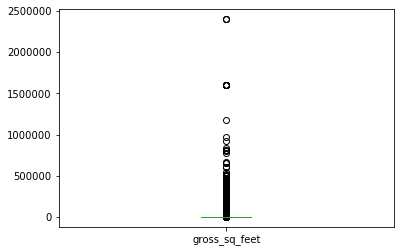

In [63]:
fig1 = property_df['gross_sq_feet'].plot.box()

In [64]:
# Dropping resi/comm_units
property_df = property_df.drop(columns = ['resi_units', 'comm_units'])

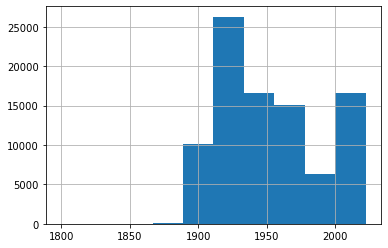

In [65]:
property_df['year_built'].hist()

In [66]:
# Mean imputing year_built, since feature is approximately Normally distributed

year_mean = property_df['year_built'].mean()
property_df['year_built'] = property_df['year_built'].fillna(value = year_mean)

In [67]:
# Creating a parquet file to read in the same data to a sdf down below
property_df.to_parquet('../raw_data/property_sdf.parquet')

In [68]:
property_sdf = spark.read.parquet('../raw_data/property_sdf.parquet')

In [69]:
feet_q1 = property_df['gross_sq_feet'].quantile(.25)
feet_q3 = property_df['gross_sq_feet'].quantile(.75)
feet_iqr = feet_q3 - feet_q1
feet_lower = feet_q1 - (1.5 * feet_iqr)
feet_upper = feet_q3 + (1.5 * feet_iqr)

sale_q1 = property_df['sale_price'].quantile(.25)
sale_q3 = property_df['sale_price'].quantile(.75)
sale_iqr = sale_q3 - sale_q1
sale_lower = sale_q1 - (1.5 * sale_iqr)
sale_upper = sale_q3 + (1.5 * sale_iqr)

In [70]:
# property_sdf = property_sdf.select('*').where(property_sdf['gross_sq_feet'] > feet_lower)
# property_sdf = property_sdf.select('*').where(property_sdf['gross_sq_feet'] < feet_upper)

# Un-comment code above the line and comment out code below the line to see how many rows were removed when removing outliers
# for gross_sq_feet
# print(property_sdf.count())


'---------------------------------------------------------------------------------------------------------------------'

property_sdf = property_sdf.select('*').where(property_sdf['sale_price'] > sale_lower)
property_sdf = property_sdf.select('*').where(property_sdf['sale_price'] < sale_upper)

property_sdf.count()

# Lost too many rows when removing 'outliers' in square footage. About 50% of rows were filtered out.
# Assumption will be that the values here just have very high variance, and what look like outliers should be considered valid data points

90400

In [71]:
# Code taken from - https://www.geeksforgeeks.org/pyspark-split-dataframe-into-equal-number-of-rows/
# Searched for 'how to partition by rows pyspark df'

# Partitioning the pyspark yellow_df into 4 parts
# Converting the entire yellow_df toPandas at once killed my kernel repeatedly

n_splits = 4
each_len = yellow.count() // n_splits
copy_yellow = yellow

yellow_pd_partitions = ['yellow_pd_1', 'yellow_pd_2', 'yellow_pd_3', 'yellow_pd_4']

i = 0
while i < n_splits:
    temp_yellow = copy_yellow.limit(each_len)
    copy_yellow = copy_yellow.subtract(temp_yellow)
    yellow_pd_partitions[i] = temp_yellow.toPandas()
    print(f'Partition {i + 1} done.')
    i += 1
    
yellow_pd = pd.concat([yellow_pd_partitions[0], yellow_pd_partitions[1]])
yellow_pd = pd.concat([yellow_pd, yellow_pd_partitions[2]])
yellow_pd = pd.concat([yellow_pd, yellow_pd_partitions[3]])

Partition 1 done.


Partition 2 done.


Partition 3 done.


Partition 4 done.


In [72]:
# Removing outliers manually - had to convert to a Pandas dataframe to filter out based on values

fare_q1 = yellow_pd['fare_amount'].quantile(.25)
fare_q3 = yellow_pd['fare_amount'].quantile(.75)
fare_iqr = fare_q3 - fare_q1
fare_lower = fare_q1 - (1.5 * fare_iqr)
fare_upper = fare_q3 - (1.5 * fare_iqr)

tip_q1 = yellow_pd['tip_amount'].quantile(.25)
tip_q3 = yellow_pd['tip_amount'].quantile(.75)
tip_iqr = tip_q3 - tip_q1
tip_lower = tip_q1 - (1.5 * tip_iqr)
tip_upper = tip_q3 - (1.5 * tip_iqr)

total_q1 = yellow_pd['total_amount'].quantile(.25)
total_q3 = yellow_pd['total_amount'].quantile(.75)
total_iqr = total_q3 - total_q1
total_lower = total_q1 - (1.5 * total_iqr)
total_upper = total_q3 - (1.5 * total_iqr)

trip_q1 = yellow_pd['trip_distance'].quantile(.25)
trip_q3 = yellow_pd['trip_distance'].quantile(.75)
trip_iqr = trip_q3 - trip_q1
trip_lower = trip_q1 - (1.5 * trip_iqr)
trip_upper = trip_q3 - (1.5 * trip_iqr)

In [73]:
# The underlying distribution of fare_amount seems to be left-skewed. We calculated outlier bounds as normal, but when
# you try stay within the upper bound, you get rid of 98% of data.

# An upper bound for detecting outliers will not be taken into consideration

yellow.select('*').where(yellow['fare_amount'] < fare_upper).count()

128414

In [74]:
(12626743 - 128414) / (12626743) * 100

98.98299981238233

In [75]:
yellow = yellow.select('*').where(yellow['fare_amount'] > fare_lower)
#yellow = yellow.select('*').where(yellow['fare_amount'] < fare_upper)

yellow = yellow.select('*').where(yellow['tip_amount'] > tip_lower)
#yellow = yellow.select('*').where(yellow['tip_amount'] < tip_upper)

yellow = yellow.select('*').where(yellow['total_amount'] > total_lower)
#yellow = yellow.select('*').where(yellow['total_amount'] < total_upper)

yellow = yellow.select('*').where(yellow['trip_distance'] > trip_lower)
#yellow = yellow.select('*').where(yellow['trip_distance'] < trip_upper)

## Strange pattern / anomaly about the data -

When trying to remove outliers that are greater than any individual feature's upper bound, as calculated by the IQR, this always results in extreme amounts of data being lost. What this tells us about the data itself, taxi trip data, should be discussed

You can observe this below by uncommenting the cell below. If you do run it, then you'll need to re-read yellow in

In [76]:
'''
display((yellow.select('*').where(yellow['fare_amount'] < fare_upper)).limit(3))
print(yellow.select('*').where(yellow['fare_amount'] < fare_upper).count())

display((yellow.select('*').where(yellow['tip_amount'] < tip_upper)).limit(3))
display((yellow.select('*').where(yellow['tip_amount'] < tip_upper).count()))

display((yellow.select('*').where(yellow['total_amount'] < total_upper)).limit(3))
display((yellow.select('*').where(yellow['total_amount'] < total_upper)).count())
'''

"\ndisplay((yellow.select('*').where(yellow['fare_amount'] < fare_upper)).limit(3))\nprint(yellow.select('*').where(yellow['fare_amount'] < fare_upper).count())\n\ndisplay((yellow.select('*').where(yellow['tip_amount'] < tip_upper)).limit(3))\ndisplay((yellow.select('*').where(yellow['tip_amount'] < tip_upper).count()))\n\ndisplay((yellow.select('*').where(yellow['total_amount'] < total_upper)).limit(3))\ndisplay((yellow.select('*').where(yellow['total_amount'] < total_upper)).count())\n"

## 5. Typecasting
Making sure that all columns are appropriately typed

There are several columns that we need to adjust the type for. They'll be listed below with their justifications

### Yellow -
- Location IDs: int - See above

In [77]:
yellow.withColumn('pulocation_id', yellow['pulocation_id'].cast('int'))

tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,ratecode_id,pulocation_id,dolocation_id,payment_type,fare_amount,tip_amount,total_amount
2022-01-01 00:35:40,2022-01-01 00:53:29,3.8,1.0,142,236,1,14.5,3.65,21.95
2022-01-01 00:33:43,2022-01-01 00:42:07,2.1,1.0,236,42,1,8.0,4.0,13.3
2022-01-01 00:53:21,2022-01-01 01:02:19,0.97,1.0,166,166,1,7.5,1.76,10.56
2022-01-01 00:25:21,2022-01-01 00:35:23,1.09,1.0,114,68,2,8.0,0.0,11.8
2022-01-01 00:36:48,2022-01-01 01:14:20,4.3,1.0,68,163,1,23.5,3.0,30.3
2022-01-01 00:40:15,2022-01-01 01:09:48,10.3,1.0,138,161,1,33.0,13.0,56.35
2022-01-01 00:20:50,2022-01-01 00:34:58,5.07,1.0,233,87,1,17.0,5.2,26.0
2022-01-01 00:13:04,2022-01-01 00:22:45,2.02,1.0,238,152,2,9.0,0.0,12.8
2022-01-01 00:30:02,2022-01-01 00:44:49,2.71,1.0,166,236,1,12.0,2.25,18.05
2022-01-01 00:48:52,2022-01-01 00:53:28,0.78,1.0,236,141,2,5.0,0.0,8.8


# LOOK HERE - check that location ids are int

In [78]:
yellow.printSchema()

root
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecode_id: double (nullable = true)
 |-- pulocation_id: long (nullable = true)
 |-- dolocation_id: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



### Property -
- year_built: int - See above

In [79]:
# Casting year_built column to int
property_df = property_df.astype({'year_built': int})

## 6. Filtering

### Yellow -

There are ___ attributes that change the data drastically depending on their value. They are:

- ratecode_id: Depending on the `ratecode_id`, the trip data refers to airport trips, group rides or negotiated fare. In an earlier assumption, I posited that shared rides wouldn't have an overt effect on fare / distance / tip, so left that in. However, airport trips and negotiated fares would. They also make up a tiny part of the overall dataset -
- payment_type: As this analysis is interested in tips, it has been provided in the data dictionary that tips are only recorded for payment_type = 1. That is, a credit card was used. Other values of payment_type have no tip recorded, and if put into a model, will introduce massive bias
- Manual inspection of the data also revealed that 

In [80]:
yellow.limit(3)

tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,ratecode_id,pulocation_id,dolocation_id,payment_type,fare_amount,tip_amount,total_amount
2022-01-01 00:35:40,2022-01-01 00:53:29,3.8,1.0,142,236,1,14.5,3.65,21.95
2022-01-01 00:33:43,2022-01-01 00:42:07,2.1,1.0,236,42,1,8.0,4.0,13.3
2022-01-01 00:53:21,2022-01-01 01:02:19,0.97,1.0,166,166,1,7.5,1.76,10.56


In [81]:
# Filtering relevant rows based on ratecode_id value and overwriting unfiltered yellow dataframe

df_1 = yellow.select('*').where(yellow['ratecode_id'] == 1)
df_2 = yellow.select('*').where(yellow['ratecode_id'] == 6)

original_yellow = yellow.count()

print(f'Full yellow dataset has {original_yellow} rows\n')
print(f'ratecode_id = 1 has {df_1.count()} rows')
print(f'ratecode_id = 2 has {df_2.count()} rows\n')

yellow = df_1.union(df_2)
print(f'Filtered yellow dataset has {yellow.count()} rows')
print(f'Should have {df_1.count() + df_2.count()} rows')

percentage = yellow.count() / original_yellow
print(f'{round(percentage * 100, 2)}% of rows retained')

Full yellow dataset has 12603324 rows

ratecode_id = 1 has 11645297 rows
ratecode_id = 2 has 97 rows



Filtered yellow dataset has 11645394 rows
Should have 11645394 rows


92.4% of rows retained


In [82]:
df_3 = yellow.select('*').where(yellow['payment_type'] == 1)

print(f'payment_type = 1 has {df_3.count()} rows')
print(f'Filtered yellow has {yellow.count()} rows')

print(f'{round(df_3.count() / yellow.count() * 100, 2)}% of rows retained')

yellow = yellow.select('*').where(yellow['payment_type'] == 1)

payment_type = 1 has 9244848 rows


Filtered yellow has 11645394 rows


79.39% of rows retained


In [83]:
# Negative amount values can be seen. Even for just these 10 rows displayed, if one were to make the argument that a - sign was
# input incorrectly, the tip_amount still far outweighs the total_amount in most cases. This is either money laundering or 
# errors

display(yellow.orderBy('total_amount').limit(10))

yellow = yellow.select('*').where(yellow['total_amount'] > 0)

# Follow similar (real-world) logic to filter out incorrect values for other attributes
yellow = yellow.select('*').where(yellow['trip_distance'] > 0)
yellow = yellow.select('*').where(yellow['fare_amount'] > 0)
yellow = yellow.select('*').where(yellow['tip_amount'] > 0)

percentage = round(yellow.count() / original_yellow * 100, 2)
print(f'After all that, yellow is left with {yellow.count()} rows: {percentage}% of original size')

tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,ratecode_id,pulocation_id,dolocation_id,payment_type,fare_amount,tip_amount,total_amount
2022-01-02 10:34:49,2022-01-02 10:35:33,0.0,1.0,264,264,1,0.0,0.0,0.0
2022-01-02 14:19:54,2022-01-02 14:20:06,0.0,1.0,193,193,1,0.0,0.0,0.0
2022-01-02 11:36:06,2022-01-02 11:37:06,0.0,1.0,193,193,1,0.0,0.0,0.0
2022-01-02 11:11:59,2022-01-02 11:12:55,0.0,1.0,193,193,1,0.0,0.0,0.0
2022-01-02 13:39:07,2022-01-02 13:40:31,0.0,1.0,193,193,1,0.0,0.0,0.0
2022-01-02 12:07:12,2022-01-02 12:07:53,0.0,1.0,193,7,1,0.0,0.0,0.0
2022-01-01 02:46:39,2022-01-01 03:31:48,0.0,1.0,61,61,1,0.0,0.0,0.0
2022-01-02 12:33:59,2022-01-02 12:35:21,0.0,1.0,7,193,1,0.0,0.0,0.0
2022-01-02 11:04:05,2022-01-02 11:04:47,0.0,1.0,193,193,1,0.0,0.0,0.0
2022-01-02 13:56:36,2022-01-02 13:56:52,0.0,1.0,7,7,1,0.0,0.0,0.0


After all that, yellow is left with 8933245 rows: 70.88% of original size


## 7. Outlier Removal 
Outliers have to be dealt with appropriately, as they can skew data

### Yellow -

Since we're dealing with pricing & trip data for taxis, and that approximately 280,000 taxi rides happen each day, I'd say that 280,000 * 30 * 4 is a sufficiently large sample size for the Central Limit Theorem to apply. We're left with just under 9 million rows after filtering, assumption holds

Therefore outlier removal won't be overly complex - simply remove whats beyond the IQR for each feature

### Property -

Outliers were examined and dealt with in _4. Handling of Missing Data_

## 5. Unit Conversion

- `[pu/do]location_id`: Geometry conversion as covered in Tutorial 2
- `trip_distance`: Units are American - convert to metric units
- all `fare` quantities are in USD
- `gross_sq_feet` would be more interpretable as `gross_sq_metres`

### Yellow -

In [84]:
yellow.limit(1)

tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,ratecode_id,pulocation_id,dolocation_id,payment_type,fare_amount,tip_amount,total_amount
2022-01-01 00:35:40,2022-01-01 00:53:29,3.8,1.0,142,236,1,14.5,3.65,21.95


In [85]:
# Converting the PU/DO Location IDs to GEOMETRY

#Code attributed to tute2

sf = gpd.read_file("../raw_data/taxi_zones.shp")
zones = pd.read_csv("../raw_data/taxi+_zone_lookup.csv")

sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [86]:
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

In [87]:
# Trip distance: 1.6 miles = 1 km

yellow = yellow.withColumn('trip_distance', yellow['trip_distance'] * 1.6)
yellow.limit(3)

tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,ratecode_id,pulocation_id,dolocation_id,payment_type,fare_amount,tip_amount,total_amount
2022-01-01 00:35:40,2022-01-01 00:53:29,6.08,1.0,142,236,1,14.5,3.65,21.95
2022-01-01 00:33:43,2022-01-01 00:42:07,3.3600000000000003,1.0,236,42,1,8.0,4.0,13.3
2022-01-01 00:53:21,2022-01-01 01:02:19,1.552,1.0,166,166,1,7.5,1.76,10.56


### Fare:
USD -> AUD for interpretability
Using current FX rates at time of writing this. Will be slightly different, but an incorrect / outdated conversion rate wouldn't affect results of study

Current conversion rate: 1 USD = 1.44 AUD

In [88]:
yellow = yellow.withColumn('total_amount', yellow['total_amount'] * 1.44)
yellow = yellow.withColumn('fare_amount', yellow['fare_amount'] * 1.44)
yellow = yellow.withColumn('tip_amount', yellow['tip_amount'] * 1.44)

## Property -

In [89]:
# 1 gross square foot = 0.09290304 metres sq
property_df['gross_sq_metres'] = property_df['gross_sq_feet'].apply(lambda x: x * 0.09290304)
property_df = property_df.drop(columns = ['gross_sq_feet'])

In [90]:
# Isolating the Building Class tag (number) so that it can be easily visualized / one-hot-encoded later

property_df['building_class'] = property_df['building_class'].str[0:3]

## Borough

Numbers to borough name

1 = manhattan
2 = bronx
3 = brooklyn
4 = queens
5 = staten_island

In [91]:
property_df['borough'] = property_df['borough'].astype('str')

In [92]:
property_df['borough'] = property_df['borough'].str.replace('1','manhattan')
property_df['borough'] = property_df['borough'].str.replace('2','bronx')
property_df['borough'] = property_df['borough'].str.replace('3','brooklyn')
property_df['borough'] = property_df['borough'].str.replace('4','queens')
property_df['borough'] = property_df['borough'].str.replace('5','staten_island')

In [93]:
property_df

,borough,neighbourhood,building_class,year_built,sale_price,gross_sq_metres
0,bronx,BATHGATE,01,1952,720000,261.986573
1,bronx,BATHGATE,01,1910,499999,117.057830
2,bronx,BATHGATE,01,1910,599000,120.402340
3,bronx,BATHGATE,01,1910,455000,120.402340
4,bronx,BATHGATE,01,1899,540000,150.688731
...,...,...,...,...,...,...
8959,staten_island,WOODROW,02,2001,618000,238.296298
8960,staten_island,WOODROW,05,1953,1000,0.000000
8961,staten_island,WOODROW,05,1953,40000,0.000000
8962,staten_island,WOODROW,05,1953,2000,0.000000


# Last adjustments to data to prepare for model

# Saving the clean data as new parquet files

## Need it in pandas / df

In [94]:
import os

In [95]:
output_relative_dir = '../raw_data/'
target_dir = 'clean_data/'
if not os.path.exists(output_relative_dir + target_dir):
    os.makedirs(output_relative_dir + target_dir)

# Yellow -

In [96]:
yellow.write.parquet('../clean_data/yellow_clean.parquet')

In [100]:
type(yellow)

pyspark.sql.dataframe.DataFrame

In [101]:
test = spark.read.parquet('../clean_data/yellow_clean.parquet')

# Property -

In [97]:
property_df.to_parquet('../clean_data/property_clean.parquet')

## GDF -

In [98]:
gdf.to_csv('../clean_data/gdf.csv')

In [99]:
t2 = datetime.now()

time_taken = t2 - t1
print(f'This notebook took {time_taken} to run.')
minutes_taken = round(time_taken.total_seconds() / 60, 2)
print(f'This notebook took {minutes_taken} minutes to run.')

This notebook took 0:04:57.674220 to run.
This notebook took 4.96 minutes to run.
